# Ciencia de datos de clasificación

Importar librerías

In [199]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)
from imblearn.under_sampling import RandomUnderSampler
import mlflow
import mlflow.tensorflow

Importar datos limpios

In [252]:
df=pd.read_csv("listings_limpio.csv")

# Alistamiento de datos

Visualizar dataframe

In [253]:
df.drop(columns=['id'], inplace=True)
df.shape

(17664, 39)

Definir el target

In [254]:
df['Target']= (df['review_scores_rating']>=4.8).astype(int)
df['Target'].value_counts()


Target
0    11341
1     6323
Name: count, dtype: int64

Borrar la variable que se usó para definir el target

In [255]:
cols_review= [c for c in df.columns if "review_scores" in c]
cols_review

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [256]:
df.drop(columns=cols_review, inplace=True)

In [257]:
df.drop(columns='neighbourhood_cleansed',inplace=True)

In [258]:
vars_a_quitar = [
    'bathrooms',
    'bedrooms',
    'TV',
    'Smoke_alarm_home_safety'
    ]
df.drop(columns=vars_a_quitar,inplace=True)

### Ordenar feats

In [259]:
cols_string = df.select_dtypes(include=['object', 'string']).columns.tolist()

In [260]:
cols_bool = df.select_dtypes(include=['bool']).columns.tolist()
df[cols_bool] = df[cols_bool].astype(int)

In [261]:
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_num.remove('Target')
cols_bin= [
    c for c in cols_num
    if df[c].dropna().nunique() == 2 and df[c].dropna().isin([0, 1]).all()
]
cols_num=[c for c in cols_num if c not in cols_bin]

In [262]:
feats = cols_num+cols_bin+cols_string
print(len(feats),feats)

27 ['host_response_rate', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'reviews_per_month', 'Wifi', 'Air_conditioning', 'Kitchen_and_dining', 'Washer_dryer', 'Safe', 'Refrigerator', 'Essentials', 'Services', 'property_Entire_Place', 'property_Hotel_Room', 'property_Other', 'property_Private_Room', 'property_Shared_Room']


In [263]:
df=df[feats+['Target']]
df.head(5)

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,availability_365,...,Safe,Refrigerator,Essentials,Services,property_Entire_Place,property_Hotel_Room,property_Other,property_Private_Room,property_Shared_Room,Target
0,100,100,40.41476,-3.70418,2,2.0,157.0,5,50,342,...,0,0,0,0,1,0,0,0,0,0
1,100,100,40.42247,-3.70577,2,3.0,143.0,5,50,341,...,0,0,0,0,1,0,0,0,0,0
2,100,99,40.41884,-3.69655,4,2.0,65.0,1,30,299,...,0,1,1,0,0,0,0,1,0,0
3,100,100,40.42252,-3.70250,2,1.0,116.0,30,360,305,...,0,1,1,1,1,0,0,0,0,0
4,100,100,40.42252,-3.70250,2,2.0,79.0,30,360,317,...,0,1,1,1,1,0,0,0,0,0


### Separar en train y test

In [264]:
train = df.sample(frac=0.8, random_state=100)
x_train=train.drop(columns=df.columns[-1])
x_train.head()
y_train=train['Target']

In [265]:
test = df.drop(train.index)
x_test=test.drop(columns=df.columns[-1])
x_test.head()
y_test=test['Target']

In [266]:
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

In [268]:
print(train.shape)
print(val.shape)
print(test.shape)

(11305, 28)
(2826, 28)
(3533, 28)


### Balancear train

In [269]:
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
print(y_train.value_counts())
train = pd.concat([x_train, y_train], axis=1) 

Target
0    5071
1    5071
Name: count, dtype: int64


### Procesar variables de entrada

In [270]:
def dataframe_to_dataset(dataframe, shuffle=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    return ds

In [271]:
batch_size = 32

train_ds = dataframe_to_dataset(train, shuffle=True).batch(batch_size)
val_ds   = dataframe_to_dataset(val, shuffle=False).batch(batch_size)
test_ds  = dataframe_to_dataset(test, shuffle=False).batch(batch_size)

In [272]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feat_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset, is_string=False):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")  
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feat_ds)
    return lookup(feature)

In [273]:
inputs = []
for i in cols_num:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in cols_bin:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cols_string:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [274]:
feats_encoded=[]
len_feats=len(feats_encoded)
for i,feat in enumerate(cols_num):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_bin):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, False)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_string):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

all_feats = keras.layers.concatenate(feats_encoded)
len_feats

27

## Red neuronal de clasificación

### Correr con MLFLow

In [250]:
# Construir modelo
capa1= keras.layers.Dense(32, activation='relu')(all_feats)
capa2 = keras.layers.Dense(32, activation='relu')(capa1)
capa3 = keras.layers.Dense(32, activation='relu')(capa2)
model_layers = keras.layers.Dense(1, activation='tanh')(capa3)
model = keras.Model(inputs, model_layers)

#Definir optimizador y compilar
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.4),
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision',thresholds=0.4),
        keras.metrics.Recall(name='recall',thresholds=0.4)
    ]
)

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#Definir experimento y ruta
mlflow.set_tracking_uri("file:///C:/mlruns_proy2")
mlflow.set_experiment("ACTD - CLASIFICACIÓN")

with mlflow.start_run(run_name="RUN 11"):
    #Definir parámetros
    mlflow.log_params({
        "modelo": "DNN",
        "activacion_ocultas":"TANH",
        "n_capas_oculttas": 3,
        "n_neuronas": 32,
        "learning_rate": 1e-3,
        "epochs_max": 50,
        "var_eliminadas": 'camas, baños, cuartos ',
        'threshold': 0.4
    })

    #Entrenar modelo
    history = model.fit(
        train_ds,
        epochs=50,
        validation_data=val_ds
    )

    #Resultados
    test_results = model.evaluate(test_ds, verbose=0)
    test_loss = test_results[0]
    test_acc  = test_results[1]
    test_auc  = test_results[2]
    test_pre = test_results[3]
    test_rec = test_results[4]

    # Métricas de última época en train/val (del history)
    train_loss_final = history.history["loss"][-1]
    val_loss_final   = history.history["val_loss"][-1]
    train_auc_final  = history.history["auc"][-1]
    val_auc_final    = history.history["val_auc"][-1]

    #Guardar las métricas
    mlflow.log_metrics({
        "train_loss_final": train_loss_final,
        "val_loss_final":   val_loss_final,
        "train_auc_final":  train_auc_final,
        "val_auc_final":    val_auc_final,
        "test_loss":        test_loss,
        "test_accuracy":    test_acc,
        "test_auc":         test_auc,
        "test_precision":   test_pre,
        "test_recall":      test_rec
    })

    #Registrar history
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("loss",      history.history["loss"][epoch],      step=epoch)
        mlflow.log_metric("val_loss",  history.history["val_loss"][epoch],  step=epoch)

    #Guardar modelo
    mlflow.tensorflow.log_model(model, "model")

    mlflow.end_run(status='FINISHED')

Epoch 1/50
354/354 [==============================] - 3s 3ms/step - loss: 0.6116 - accuracy: 0.6383 - auc: 0.6656 - precision: 0.4961 - recall: 0.5212 - val_loss: 0.5905 - val_accuracy: 0.6681 - val_auc: 0.7057 - val_precision: 0.5422 - val_recall: 0.4877
Epoch 2/50
354/354 [==============================] - 1s 2ms/step - loss: 0.5795 - accuracy: 0.6693 - auc: 0.7199 - precision: 0.5348 - recall: 0.6023 - val_loss: 0.5753 - val_accuracy: 0.6472 - val_auc: 0.7278 - val_precision: 0.5063 - val_recall: 0.7163
Epoch 3/50
354/354 [==============================] - 1s 2ms/step - loss: 0.5609 - accuracy: 0.6783 - auc: 0.7469 - precision: 0.5423 - recall: 0.6615 - val_loss: 0.5769 - val_accuracy: 0.6596 - val_auc: 0.7302 - val_precision: 0.5209 - val_recall: 0.6493
Epoch 4/50
354/354 [==============================] - 1s 2ms/step - loss: 0.5450 - accuracy: 0.6852 - auc: 0.7630 - precision: 0.5497 - recall: 0.6783 - val_loss: 0.6082 - val_accuracy: 0.6755 - val_auc: 0.7258 - val_precision: 0.54

2025/11/28 20:03:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 20:03:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\adri_\AppData\Local\Temp\tmp6w8cl9j2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\adri_\AppData\Local\Temp\tmp6w8cl9j2\model\data\model\assets
2025/11/28 20:04:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Mejor modelo

Epoch 1/70
317/317 [==============================] - 2s 3ms/step - loss: 0.8844 - accuracy: 0.5792 - auc: 0.5976 - precision: 0.5721 - recall: 0.6281 - val_loss: 0.6527 - val_accuracy: 0.6203 - val_auc: 0.6571 - val_precision: 0.4773 - val_recall: 0.6010
Epoch 2/70
317/317 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.6244 - auc: 0.6650 - precision: 0.6131 - recall: 0.6746 - val_loss: 0.6469 - val_accuracy: 0.6171 - val_auc: 0.6801 - val_precision: 0.4777 - val_recall: 0.7054
Epoch 3/70
317/317 [==============================] - 1s 2ms/step - loss: 0.6365 - accuracy: 0.6346 - auc: 0.6861 - precision: 0.6247 - recall: 0.6742 - val_loss: 0.6101 - val_accuracy: 0.6532 - val_auc: 0.6974 - val_precision: 0.5155 - val_recall: 0.5734
Epoch 4/70
317/317 [==============================] - 1s 2ms/step - loss: 0.6290 - accuracy: 0.6383 - auc: 0.6975 - precision: 0.6302 - recall: 0.6697 - val_loss: 0.6259 - val_accuracy: 0.6267 - val_auc: 0.7045 - val_precision: 0.48

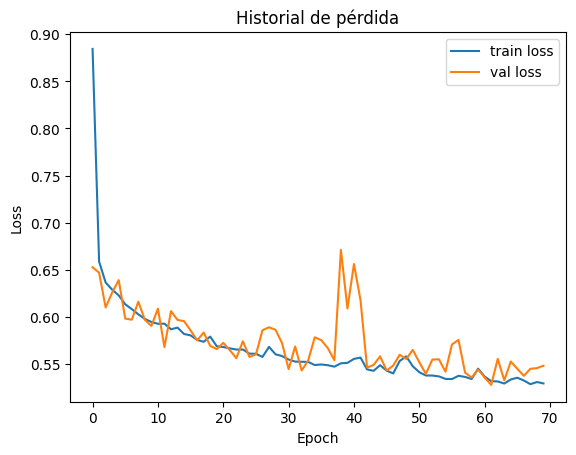

Accuracy : 0.6614775061607361
Precision: 0.5156075954437256
Recall   : 0.7388178706169128
ROC-AUC  : 0.7511408925056458


In [280]:
# Construir modelo
capa1= keras.layers.Dense(16, activation='relu')(all_feats)
capa2 = keras.layers.Dense(16, activation='relu')(capa1)
model_layers = keras.layers.Dense(1, activation='tanh')(capa2)
modelo_final = keras.Model(inputs, model_layers)

#Definir optimizador y compilar
optimizer = keras.optimizers.Adam(learning_rate=0.001)
modelo_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#Entrenar modelo
history = modelo_final.fit(
    train_ds,
    epochs=70,
    validation_data=val_ds
)

#Gráfica de perdida
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Historial de pérdida")
plt.legend(); plt.show()


test_results = modelo_final.evaluate(test_ds, verbose=0)
test_loss = test_results[0]
test_acc  = test_results[1]
test_auc  = test_results[2]
test_pre = test_results[3]
test_rec = test_results[4]

print("Accuracy :", test_acc)
print("Precision:", test_pre)
print("Recall   :", test_rec)
print("ROC-AUC  :", test_auc)


In [283]:
import os

ruta_salida = r"C:\modelos_andes"
os.makedirs(ruta_salida, exist_ok=True)

modelo_final.save(os.path.join(ruta_salida, "modelo_clasificacion_andes.keras"))